### Federated CNN no autoencoder 3x3 Filter

In [1]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

# === Model Paths ===
study_models = {
    "SDY569": "models/SDY569_local_cnn.keras",
    "SDY797": "models/SDY797_local_cnn.keras",
    "SDY1737": "models/SDY1737_local_cnn.keras"
}


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error

# Paths
studies = ["SDY569", "SDY797", "SDY1737"]
standard_features = ["MIAA", "GAD65", "IA2IC", "ICA", "ZNT8", "8-12", "13-17", ">18", "Sex"]

# Directories
os.makedirs("models", exist_ok=True)
os.makedirs("figures/pdf", exist_ok=True)
os.makedirs("figures/html", exist_ok=True)

# Load pre-saved train/test data
split_data = {}
for study in studies:
    train_df = pd.read_csv(f"data/cleaned/{study}_train.csv")
    test_df  = pd.read_csv(f"data/cleaned/{study}_test.csv")

    # Fill NaNs (safety)
    train_df = train_df.fillna(0.0)
    test_df = test_df.fillna(0.0)

    # Transform labels
    train_df["log_auc"] = np.log(train_df["C_Peptide_AUC_4Hrs"])
    test_df["log_auc"] = np.log(test_df["C_Peptide_AUC_4Hrs"])

    # Extract X and y
    X_train = train_df[standard_features].values
    y_train = train_df["log_auc"].values
    X_test  = test_df[standard_features].values
    y_test  = test_df["log_auc"].values

    # Normalize (fit on train only)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Reshape
    X_train_cnn = X_train_scaled.reshape(-1, 3, 3, 1)
    X_test_cnn  = X_test_scaled.reshape(-1, 3, 3, 1)

    split_data[study] = {
        "X_train": X_train_cnn,
        "y_train": y_train,
        "X_test": X_test_cnn,
        "y_test": y_test
    }


In [4]:
all_weights = []

for study in studies:
    print(f"\nTraining local model for {study}")
    X_train = split_data[study]["X_train"]
    y_train = split_data[study]["y_train"]

    model = models.Sequential([
        layers.Input(shape=(3, 3, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
    all_weights.append(model.get_weights())  # Store model weights



Training local model for SDY569

Training local model for SDY797

Training local model for SDY1737


In [5]:
# Average weights across all local models
federated_weights = []

for i in range(len(all_weights[0])):  # Loop over weight tensors
    stacked = np.stack([w[i] for w in all_weights], axis=0)
    avg = np.mean(stacked, axis=0)
    federated_weights.append(avg)

# Create federated model and set averaged weights
federated_model = models.Sequential([
    layers.Input(shape=(3, 3, 1)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
federated_model.compile(optimizer='adam', loss='mse')
federated_model.set_weights(federated_weights)

# Save
federated_model.save("models/federated_CNN_3x3_noAutoencoder.keras")



Evaluating Federated Model on SDY569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  MSE:        0.7458
  Median MSE: 0.1163
  IQR:        0.2691


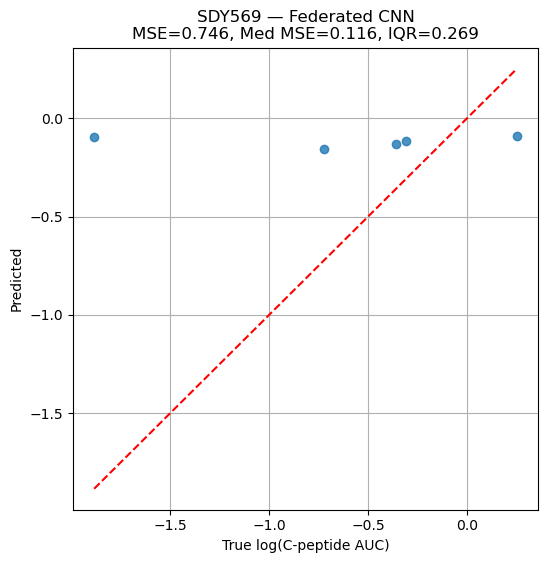


Evaluating Federated Model on SDY797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
  MSE:        0.2955
  Median MSE: 0.1201
  IQR:        0.1761


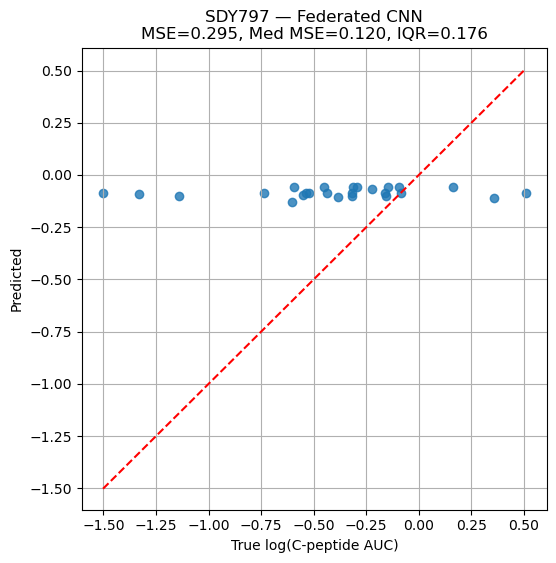


Evaluating Federated Model on SDY1737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  MSE:        0.6236
  Median MSE: 0.1669
  IQR:        0.2374


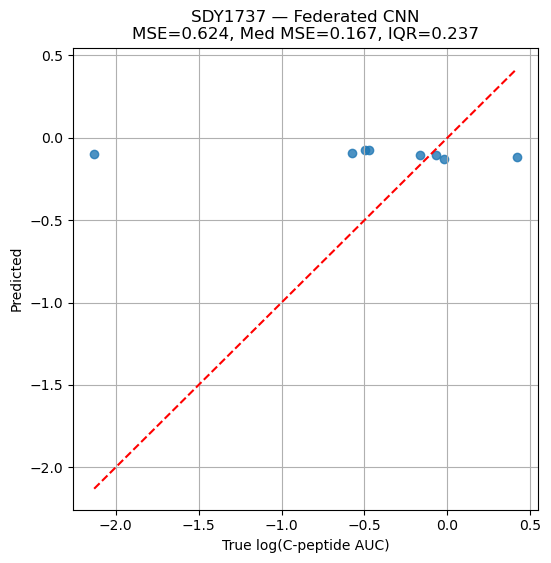

In [6]:
for study in studies:
    print(f"\nEvaluating Federated Model on {study}")
    X_test = split_data[study]["X_test"]
    y_test = split_data[study]["y_test"]

    y_pred = federated_model.predict(X_test).flatten()

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    median_mse = np.median((y_test - y_pred)**2)
    iqr = np.percentile((y_test - y_pred)**2, 75) - np.percentile((y_test - y_pred)**2, 25)

    print(f"  MSE:        {mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    # Matplotlib
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True log(C-peptide AUC)")
    plt.ylabel("Predicted")
    plt.title(f"{study} — Federated CNN\nMSE={mse:.3f}, Med MSE={median_mse:.3f}, IQR={iqr:.3f}")
    plt.grid(True)
    plt.savefig(f"figures/pdf/{study}_federated_cnn.pdf")
    plt.show()

    # Plotly
    df_plot = pd.DataFrame({"True": y_test, "Predicted": y_pred})
    fig = px.scatter(df_plot, x="True", y="Predicted", title=f"{study} — Federated CNN")
    fig.add_shape(
        type="line",
        x0=y_test.min(), y0=y_test.min(),
        x1=y_test.max(), y1=y_test.max(),
        line=dict(color="red", dash="dash")
    )
    fig.write_html(f"figures/html/{study}_federated_cnn.html")


In [9]:
# SDY797 is a problematic study with binary results that may be overly influencing the federated weights 
# === Federated Averaging Excluding SDY797 ===
excluded_study = "SDY797"
# Paths
studies_excluding_SDY797 = ["SDY569", "SDY1737"]

all_weights_excluding_SDY797 = []

for study in studies_excluding_SDY797:
    print(f"\nTraining local model for {study}")
    X_train = split_data[study]["X_train"]
    y_train = split_data[study]["y_train"]

    model = models.Sequential([
        layers.Input(shape=(3, 3, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
    all_weights_excluding_SDY797.append(model.get_weights())  # Store model weights



Training local model for SDY569

Training local model for SDY1737


In [10]:
# Average weights across all local models
federated_weights_excluding_SDY797 = []

for i in range(len(all_weights_excluding_SDY797[0])):  # Loop over weight tensors
    stacked = np.stack([w[i] for w in all_weights_excluding_SDY797], axis=0)
    avg = np.mean(stacked, axis=0)
    federated_weights_excluding_SDY797.append(avg)

# Create federated model and set averaged weights
federated_model_excluding_SDY797 = models.Sequential([
    layers.Input(shape=(3, 3, 1)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
federated_model_excluding_SDY797.compile(optimizer='adam', loss='mse')
federated_model_excluding_SDY797.set_weights(federated_weights_excluding_SDY797)

# Save
federated_model_excluding_SDY797.save("models/federated_CNN_3x3_noAutoencoder_excluding_SDY797.keras")



Evaluating Federated Model on SDY569 excluding SDY797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
  MSE:        0.6884
  Median MSE: 0.0792
  IQR:        0.1348


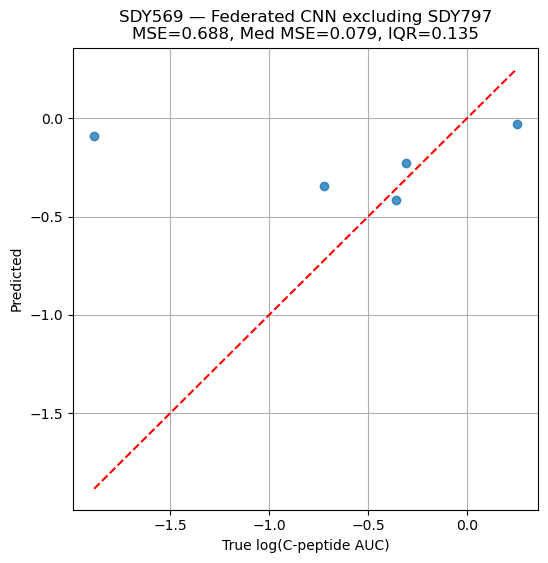


Evaluating Federated Model on SDY1737 excluding SDY797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
  MSE:        0.5704
  Median MSE: 0.1584
  IQR:        0.2360


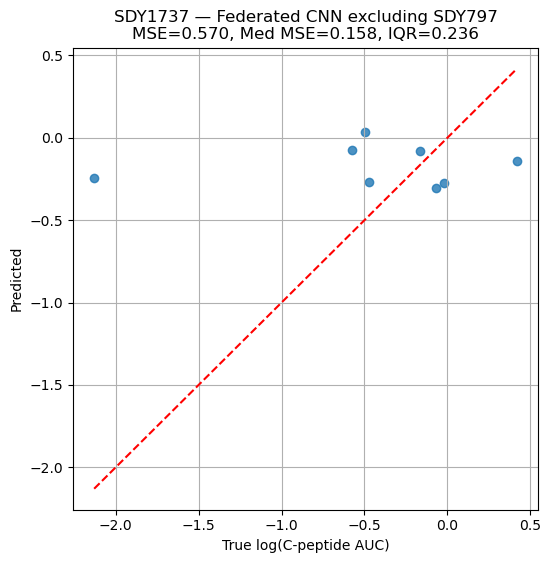

In [11]:
for study in studies_excluding_SDY797:
    print(f"\nEvaluating Federated Model on {study} excluding SDY797")
    X_test = split_data[study]["X_test"]
    y_test = split_data[study]["y_test"]

    y_pred = federated_model_excluding_SDY797.predict(X_test).flatten()

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    median_mse = np.median((y_test - y_pred)**2)
    iqr = np.percentile((y_test - y_pred)**2, 75) - np.percentile((y_test - y_pred)**2, 25)

    print(f"  MSE:        {mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    # Matplotlib
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True log(C-peptide AUC)")
    plt.ylabel("Predicted")
    plt.title(f"{study} — Federated CNN excluding SDY797\nMSE={mse:.3f}, Med MSE={median_mse:.3f}, IQR={iqr:.3f}")
    plt.grid(True)
    plt.savefig(f"figures/pdf/{study}_federated_cnn_excluding_SDY797.pdf")
    plt.show()

    # Plotly
    df_plot = pd.DataFrame({"True": y_test, "Predicted": y_pred})
    fig = px.scatter(df_plot, x="True", y="Predicted", title=f"{study} — Federated CNN excluding SDY797")
    fig.add_shape(
        type="line",
        x0=y_test.min(), y0=y_test.min(),
        x1=y_test.max(), y1=y_test.max(),
        line=dict(color="red", dash="dash")
    )
    fig.write_html(f"figures/html/{study}_federated_cnn_excluding_SDY797.html")